In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# this package is written by me and is in the same github folder
from my_ANN import ANN

In [3]:
df = pd.read_csv('train-2.csv')

In [3]:
print('number of rows: ', df.shape[0])
print('number of columns: ', df.shape[1])

number of rows:  42000
number of columns:  785


In [38]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [4]:
data = df.as_matrix()

In [280]:
X, y = data[:,1:], data[:,0]

In [281]:
# scale X to be 0 to 1
X = X/225.0

### PCA - dimension reduction

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

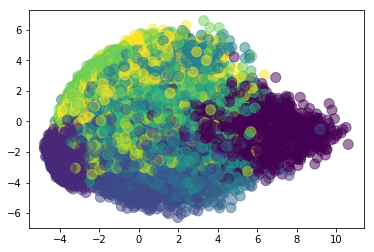

In [8]:
pca = PCA(n_components  = 2)
reduced = pca.fit_transform(X)
plt.scatter(reduced[:,0], reduced[:,1], s = 100, c = y, alpha = 0.5)
plt.show()

After reducing the dimension from 784D to 2D, i am able to plot it in a chart. Interestingsly, there are several category are far apart in this 2D chart. I am going to reduce dimension before putting into model.

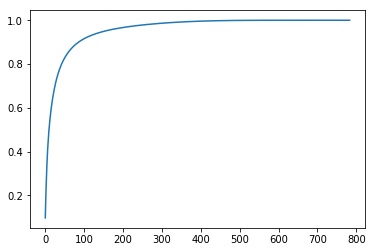

In [29]:
pca = PCA()
reduced = pca.fit_transform(X)

cumulative = []
last = 0
for v in pca.explained_variance_ratio_:
    cumulative.append(last + v)
    last = cumulative[-1]
    
plt.plot(cumulative)
plt.show()

I am going to keep 100 dimension first and keep adding dimension to see if any improvement in the final score

### Benchmark Model - Logistic Regression

In [5]:
data = shuffle(data)
X, y = data[:,1:], data[:,0]
X = X/225.0
cutoff = 0.8
Xtrain, ytrain = X[:int(0.8*len(data))], y[:int(0.8*len(data))]
Xtest, ytest = X[int(0.8*len(data)):], y[int(0.8*len(data)):]
print('number of samples in train set is ', len(Xtrain))
print('number of samples in test set is ', len(Xtest))

number of samples in train set is  33600
number of samples in test set is  8400


In [10]:
# decided to keep 300 components
pca = PCA(n_components  = 300)
Ztrain = pca.fit_transform(Xtrain)
Ztest = pca.transform(Xtest)

In [11]:
lr = LogisticRegression()

In [12]:
lr.fit(Ztrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:

print('Train set score is ', lr.score(Ztrain, ytrain))
print('Test set score is ', lr.score(Ztest, ytest))

Train set score is  0.928392857143
Test set score is  0.914761904762


### Neural Network  with Adam

In [6]:
model = ANN(300)
model.fit_adam(Xtrain, ytrain, activation='sigmoid',  learning_rate=1e-3, reg=0.01, epochs=600, batch_sz=500, print_period=100)

In [7]:
pYtrain, _ = model.forward(Xtrain, 'sigmoid')
pYtest, _ = model.forward(Xtest, 'sigmoid')
print('Final train classification_rate: ', model.score(ytrain, model.predict(pYtrain)))
print('Final test classification_rate: ', model.score(ytest, model.predict(pYtest)))

Final train classification_rate:  0.99994047619
Final test classification_rate:  0.980714285714


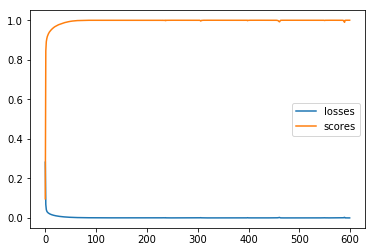

In [8]:
plt.plot(model.losses, label = 'losses')
plt.plot(model.scores, label = 'scores')
plt.legend()
plt.show()

##### The Scores have imporved a lot after using Neural Network

#### Add one more layer, Tensorflow

In [9]:
max_iter = 300
lr = 1e-3
reg = 0.01
print_period = 100

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

K = len(set(ytrain))
M1 = 100
M2 = 100
W1_init = np.random.randn(D, M1) / np.sqrt(D)
b1_init = np.random.randn(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
b2_init = np.random.randn(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2)
b3_init = np.random.randn(K)


X = tf.placeholder(tf.float32, shape = (None, D), name = 'X')
T = tf.placeholder(tf.float32, shape = (None, K), name = 'T')

W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))


#first layer
Z1 = tf.nn.relu( tf.matmul(X, W1) + b1 )
#second layer
Z2 = tf.nn.relu( tf.matmul(Z1, W2) + b2 )
#this Yish is not final output yet
Yish = tf.matmul(Z2, W3) + b3
#cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T))
#use RMSProp adn momemtum
train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

predict_op = tf.argmax(Yish, 1)

LL = []
init = tf.global_variables_initializer()

In [10]:
def y2indicator(y):
    K = len(set(y))
    result = np.zeros((len(y), K))
    for i in range(len(y)):
        result[i, y[i]] = 1
    return result
ytrain_ind = y2indicator(ytrain)
ytest_ind = y2indicator(ytest)

def score(Y, T):
    return np.mean(Y == T)

In [13]:
with tf.Session() as session:
    session.run(init)
    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch= Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            ybatch = ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]
            session.run(train_op, feed_dict = {X: Xbatch, T: ybatch})
            if j % 100 == 0:
                test_cost = session.run(cost, feed_dict = {X: Xtest, T: ytest_ind})
                #print('at iteration i = %d, j = %d: cost = %.6f' %(i,j,test_cost))
                prediction_test = session.run(predict_op, feed_dict = {X: Xtest})
                accuracy = score(prediction_test, ytest)
                #print('the error rate is ', accuracy)
    prediction_train = session.run(predict_op, feed_dict = {X: Xtrain})
    prediction_test = session.run(predict_op, feed_dict = {X: Xtest})
    accuracy_train = score(prediction_train, ytrain)
    accuracy_test = score(prediction_test, ytest)
    print('Final train classification_rate: ', accuracy_train)
    print('Final test classification_rate: ', accuracy_test)

Final train classification_rate:  0.999345238095
Final test classification_rate:  0.972023809524


#### The score doesn't get imporved and two layers might be too much. However, tensorflow is much faster than my own code and easy to implement